# Wikipedia Vectors - Getting Started

In this project, we learned vector representations for Wikipedia articles and Wikidata items using [Word2vec](https://en.wikipedia.org/wiki/Word2vec) models. The original use case for Word2vec was to learn vector representations of words based on word co-occurrence statistics. The intuition is that Word2vec learns "similar" vector representations for words that occur in similar contexts. Since words that appear in similar contexts are often semantically and syntactically similar, similar words have similar vector representations (as measured using the cosine similarity, for example). 

There have been several approaches to learning vector representations of Wikipedia articles that involve using the article text or the link network. Here we apply Word2vec to reading sessions and learn vector representations of articles such that articles that tend to be visited together have similar representations. We can learn representations for [Wikidata](https://www.wikidata.org/wiki/Wikidata:Main_Page) items by simply mapping article titles within each session to Wikidata items using Wikidata sitelinks. The beauty of these Wikidata vectors is that they are trained over reading sessions for all Wikipedia language editions. Another advantage is that they implicitly give a vector representation for any article that has been mapped to a Wikidata item.

What follows are some visualizations and code examples to help you get started with using Wikipedia Vectors for your own projects.

### A Simple Embedding Class

The term 'embedding' is often used to refer to a collection of vector representations. The `WikiEmbeddings` class takes care of loading the vector data into a matrix and exposes a method for finding the nearest neighbours of an article in the embedding.

In [197]:
import numpy as np
from sklearn.preprocessing import normalize
import requests
import matplotlib.pyplot as plt
%matplotlib inline


class WikiEmbeddings:

    def __init__(self, fname):
        
        self.w2idx = {}
        self.idx2w = []
    
        with open(fname, 'rb') as f:
            
            m, n = next(f).decode('utf8').strip().split(' ')
            self.E = np.zeros((int(m), int(n)))

            for i, l in enumerate(f):
                l = l.decode('utf8').strip().split(' ')
                w = l[0]
                self.E[i] = np.array(l[1:])
                self.w2idx[w] = i
                self.idx2w.append(w)
                
        self.E = normalize(self.E)
        self.idx2w = np.array(self.idx2w)

    def most_similar(self, w, n=10, min_similarity=0.7):
        """
        Find the top-N most similar words to w, based on cosine similarity.
        As a speed optimization, only consider neighbors with a similarity
        above min_similarity
        """
        
        if type(w) is str:
            w = self.E[self.w2idx[w]]

        scores = self.E.dot(w)
        # only consider neighbours above threshold
        min_idxs = np.where(scores > min_similarity)
        ranking = np.argsort(-scores[min_idxs])[1:(n+1)]
        nn_ws = self.idx2w[min_idxs][ranking]
        nn_scores = scores[min_idxs][ranking]
        return zip(list(nn_ws), list(nn_scores))
    

### Exploring Nearest Neighbours

Here we load an embedding over English Wikipedia articles trained on reading sessions in enwiki for the first week of February 2016 (Note: we will get to using Wikidata embeddings in a bit). Then we show the nearest neighbours for some sample articles.

In [228]:
en_embedding = WikiEmbeddings('../data/2016_02_01_2016_02_07/2016_02_01_2016_02_07_vectors_en_100')

In [229]:
en_embedding.most_similar('Universe')

[(u'Observable_universe', 0.85375291632895289),
 (u'Age_of_the_universe', 0.85235642926044175),
 (u'Illustris_project', 0.85231994099886088),
 (u'Galaxy', 0.8514183810767848),
 (u'Physical_cosmology', 0.84614629914868011),
 (u'Galaxy_formation_and_evolution', 0.84448425408485028),
 (u"Hubble's_law", 0.83683439859439279),
 (u'Particle_horizon', 0.83522401669839896),
 (u'Comoving_distance', 0.83190559659819152),
 (u'Ultimate_fate_of_the_universe', 0.82325352743317803)]

In [230]:
en_embedding.most_similar('Bernese_Mountain_Dog')

[(u'Greater_Swiss_Mountain_Dog', 0.95114274564425605),
 (u'Appenzeller_Sennenhund', 0.91395230570046748),
 (u'Swiss_mountain_dog', 0.90908280486459625),
 (u'Entlebucher_Mountain_Dog', 0.90889919827633225),
 (u'St._Bernard_(dog)', 0.88576450016436092),
 (u'Newfoundland_(dog)', 0.8694045725317483),
 (u'Working_Group_(dogs)', 0.86358809878298959),
 (u'Mountain_dog', 0.84594602706820388),
 (u'Schweizerischer_Niederlaufhund', 0.81862187979827961),
 (u'Bouvier_des_Flandres', 0.81824708187226791)]

### Visualizing the Embedding using TSNE


The [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) algorithm tries to take a collection of high dimensional vecotors and find lower dimensional representations such that the relative distances between points stay preserved as well as possible. This allows us to visualize a part of the embedding in 2D. In the plot below you see the 2D t-SNE projection for the 20 most popular articles in the training data. (Note: The code for getting a readable scatter plot is a bit hairy, so the code has been factored out to a helper file)

In [231]:
import inspect, os
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(0,parentdir)
from src.getting_started_helpers import get_tsne, plot_tsne

ImportError: No module named src.getting_started_helpers

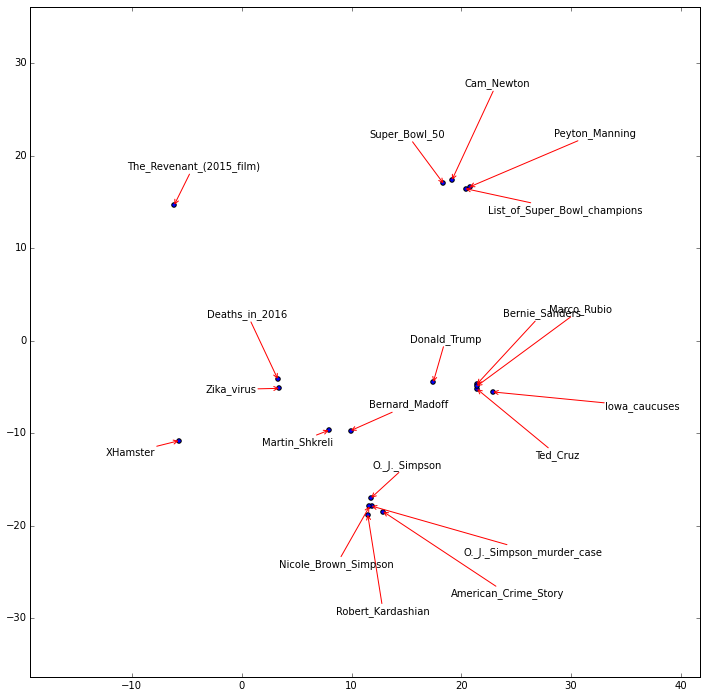

In [225]:
tsne_en_embedding = get_tsne(we_en, pca_dim = 5, n_words=1000)
plot_tsne(en_embedding, tsne_embedding, n = 20)

In [168]:
def items_to_titles(items, lang):
    """
    Input: a list of Wikidata item ids
    Output: a dictionary mapping from ids to title in lang
    
    Note: items without an articlce in lang are not included in the output
    """
    lang += 'wiki'
    payload = {'action': 'wbgetentities',
               'props': 'sitelinks/urls',
               'format': 'json',
               'ids': '|'.join(items),               
              }
    r = requests.get('https://www.wikidata.org/w/api.php', params=payload).json()
    
    return parse_wikidata_sitelinks(r, lang, True)
    
    
def titles_to_items(titles, lang):
    """
    Input: a list of article titles in lang
    Output: a dictionary mapping from titles in lang to Wikidata ids
    
    Note: articles in lang without a Wikidata id are not included in the output

    """
    lang += 'wiki'
    payload = {'action': 'wbgetentities',
               'props': 'sitelinks/urls',
               'format': 'json',
               'sites': lang,
               'titles': '|'.join(titles),
              }
    r = requests.get('https://www.wikidata.org/w/api.php', params=payload).json()
    
    return parse_wikidata_sitelinks(r, lang, False)


def parse_wikidata_sitelinks(response, lang, item_to_title):
    """
    Helper function for parsing sitelinks from Wikidata Api
    """
    d = {}
    if 'entities' not in response:
        print ('No entities in reponse')
        return d

    for item, v in response['entities'].items():
        if 'sitelinks' in v:
            if lang in v['sitelinks']:
                title = v['sitelinks'][lang]['title'].replace(' ', '_')
                if item_to_title:
                    d[item] = title
                else:
                    d[title] = item
    return d

def most_similar(embedding, title, lang, n=10, min_similarity=0.7):
    item = titles_to_items([title,], lang)[title]
    nn = embedding.most_similar(item, n=n, min_similarity=min_similarity)
    nn_items = [x[0] for x in nn]
    nn_items_to_titles = items_to_titles(nn_items, lang)
    return [(nn_items_to_titles[x[0]], x[1]) for x in nn if x[0] in nn_items_to_titles]    

In [146]:
we_all = WikiEmbeddings('../data/2016_02_01_2016_02_07/2016_02_01_2016_02_07_vectors_all_100')

In [169]:
most_similar(we_all, 'Universe', 'en')

[('Age_of_the_universe', 0.88983989409153741),
 ('Galaxy', 0.87180186370650736),
 ('Observable_universe', 0.86255352705979282),
 ('Missing_mass', 0.86211811611043809),
 ('Chronology_of_the_universe', 0.85911002864153585),
 ('Universe_(disambiguation)', 0.85866383190473128),
 ('Milky_Way', 0.85479991099154629),
 ('Metric_expansion_of_space', 0.85476181747903324)]

In [152]:
we_all.most_similar('Q1')

[('Q500699', 0.88983989409153741),
 ('Q16652009', 0.88214426616017239),
 ('Q318', 0.87180186370650736),
 ('Q221392', 0.86255352705979282),
 ('Q4422615', 0.86211811611043809),
 ('Q136407', 0.85911002864153585),
 ('Q229206', 0.85866383190473128),
 ('Q321', 0.85479991099154629),
 ('Q1129469', 0.85476181747903324),
 ('Q3199067', 0.84957357797789501)]